In [54]:
import numpy as np
import os
import glob
import scipy.ndimage as ndimage
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from skimage import feature, exposure, filters
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

In [4]:
directory_path = './data/cells'
image_files = [f for f in glob.glob(os.path.join(directory_path, '*')) if 'Edges' not in os.path.basename(f)]
images = np.array([np.array(Image.open(filename).convert('L'), dtype=np.float32) for filename in image_files])

ground_truth_image_files = [f for f in glob.glob(os.path.join(directory_path, '*')) if 'Edges' in os.path.basename(f)]
ground_truths = np.array([np.array(Image.open(filename).convert('L'), dtype=np.float32) for filename in ground_truth_image_files])

In [354]:
def compute_gradients(images, edge_type, apply_blur_gauss=False, blur_sigma=0):
    def compute_edge_strength(src, method):
        edges = None

        if method == "Roberts":
            gx_mask = np.array([[1, 0 ], [0,-1 ]])
            gy_mask = np.array([[ 0, 1 ], [ -1, 0 ]])

            vertical = ndimage.convolve(src, gx_mask)
            horizontal = ndimage.convolve(src, gy_mask)

            edges = np.sqrt(vertical**2 + horizontal**2)
            edges = edges.astype(np.uint8)

        elif method == "Sobel":
            kdepth = cv.CV_32F
            grad_x = cv.Sobel(src, kdepth, 1, 0)    
            grad_y = cv.Sobel(src, kdepth, 0, 1)
            grad = np.sqrt(grad_x**2 + grad_y**2)
            edges = (grad * 255 / grad.max()).astype(np.uint8)


        elif method == "First Order Gaussian":
            gx_mask = np.array([[-1, 1 ], [-1, 1]])
            gy_mask = np.array([[ 1, 1 ], [ -1, -1 ]])

            src = filters.gaussian(src, sigma=1)

            vertical = ndimage.convolve(src, gx_mask)
            horizontal = ndimage.convolve(src, gy_mask)
            
            edges = np.sqrt(vertical**2 + horizontal**2)
            edges = edges.astype(np.uint8)
            
        elif method == "Laplacian":
            edges = filters.laplace(image=src)

        elif method == "Laplacian of Gaussian":
            edges = ndimage.gaussian_laplace(src, 10)

        if edge_type == "Laplacian" or edge_type == "Laplacian of Gaussian":
            # Detect zero crossings
            edges = np.pad(edges, ((0, 1), (0, 1)))
            
            gx_mask = np.where(edges[:-1, :-1] - edges[:-1, 1:] < 0, 1, 0)
            gy_mask = np.where(edges[:-1, :-1] - edges[1:, :-1] < 0, 1, 0)

            edges =  (gx_mask|gy_mask).astype(float)

        elif method == "Canny":
            # This has to be done in the threshold method to expose
            # the threshold parameters so they can be changed for ROC;
            # this kind of ruins everything
            return edges

        return edges
    
    gradients = []

    for img in images:
        if apply_blur_gauss:
            img = ndimage.gaussian_filter(img, blur_sigma)

        edge_strength = compute_edge_strength(img, edge_type)
        gradients.append(edge_strength)
    
    return np.asarray(gradients)

In [355]:
def apply_threshold(images, gradients, technique, threshold, canny_sigma = 0):

    def variance_threshold(src, edges, threshold):
        win_mean = ndimage.uniform_filter(src, (5, 5))
        win_sqr_mean = ndimage.uniform_filter(src**2, (5, 5))
        win_var = win_sqr_mean - win_mean**2

        # Rescale the variance so I can actually use it
        scaled_var = ((win_var - win_var.min()) / 
               (win_var.max() - win_var.min())) * (255)

        # Mask the values accordingly
        low_variance_mask = scaled_var < threshold
        high_variance_mask = scaled_var >= threshold
        edges = np.where(low_variance_mask, 0, edges)
        edges = np.where(high_variance_mask, 1, edges)
        
        return edges

    thresholded_images = []

    for i in range(len(gradients)):
        if technique in ['Laplacian', 'Laplacian of Gaussian']:
            binary_image = variance_threshold(images[i], gradients[i], threshold=threshold)
            binary_image = (binary_image * 255).astype(np.uint8)

        elif technique == 'Canny':
            high_threshold = threshold
            low_threshold = high_threshold*0
            imgBlur = cv.GaussianBlur(images[i], (13, 13), 0)
            imgBlur = imgBlur.astype(np.uint8)
            binary_image = cv.Canny(imgBlur, low_threshold, high_threshold)
        
        else:
            _, binary_image = cv.threshold(gradients[i], threshold, 255, cv.THRESH_BINARY)
            
        binary_image = ~binary_image
        thresholded_images.append(binary_image)

    return np.asarray(thresholded_images)

In [356]:
def display_processed_images(processed_images):
    n = len(processed_images)
    cols = 3
    rows = n // cols + (1 if n % cols else 0)
    
    plt.figure(figsize=(15, rows * 5)) 
    
    for i, image in enumerate(processed_images, start=1):
        plt.subplot(rows, cols, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

[  0 255]


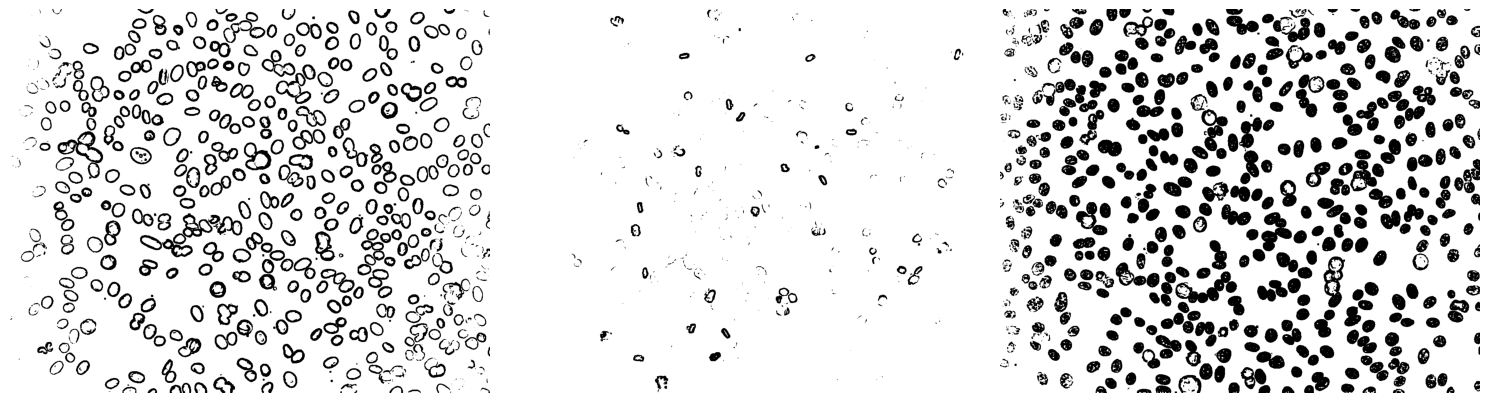

In [358]:
edge_type = 'Laplacian of Gaussian'
threshold = 10
gradients = compute_gradients(images, edge_type=edge_type, apply_blur_gauss=False, blur_sigma=5)
thresholded_images = apply_threshold(images, gradients, technique=edge_type, threshold=threshold, canny_sigma=1)

print(np.unique(thresholded_images))

display_processed_images(processed_images=thresholded_images)

Canny


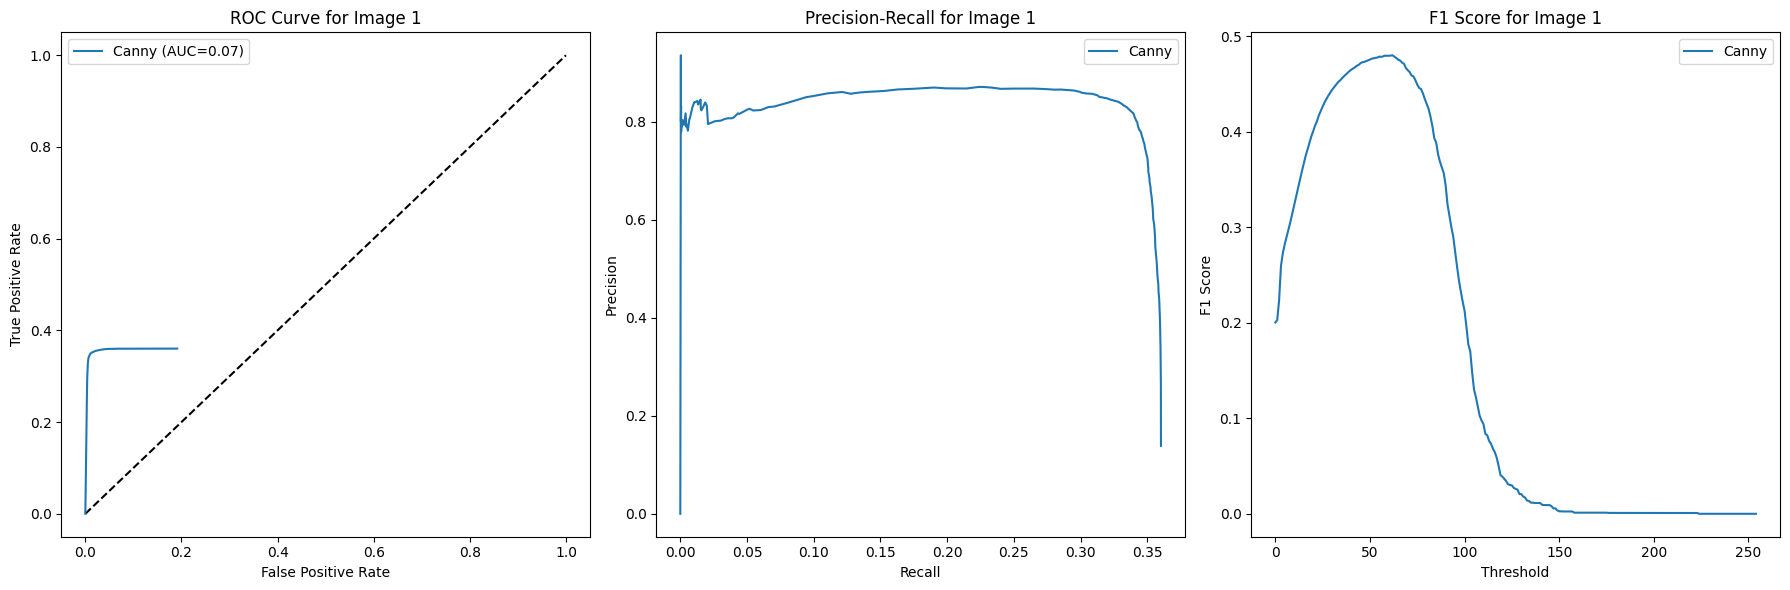

Canny


KeyboardInterrupt: 

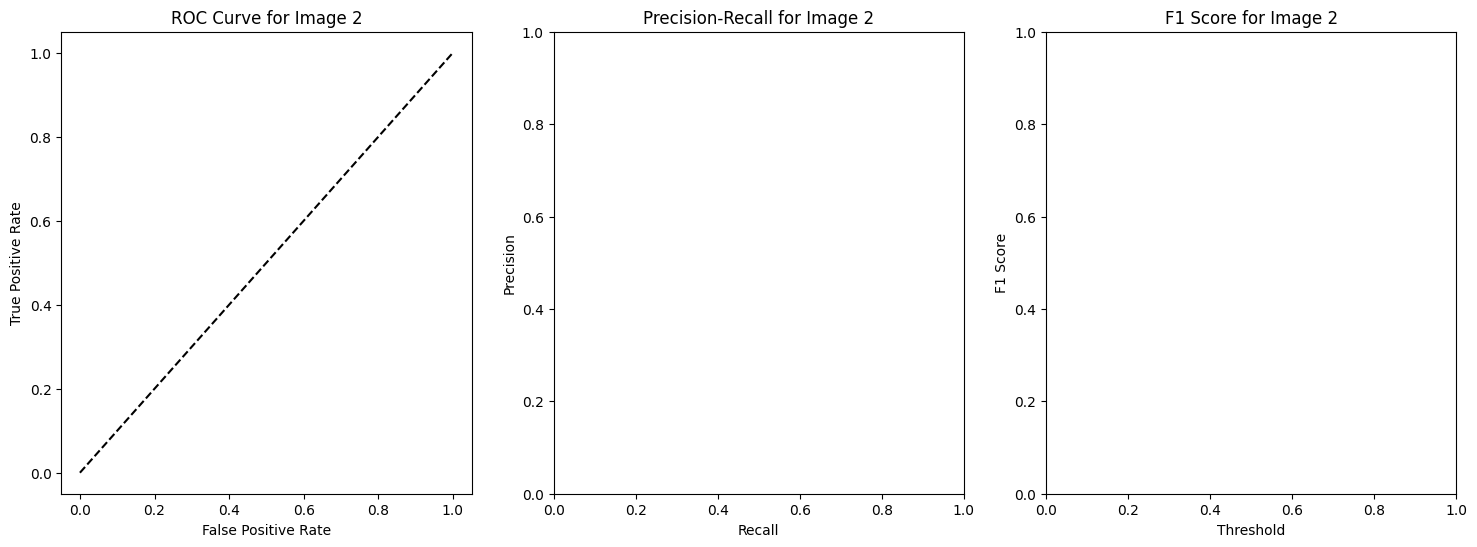

In [311]:
methods_settings = [
    #{"name": "Laplacian", "apply_blur_gauss": False, "blur_sigma": 1},
    #{"name": "Laplacian of Gaussian", "apply_blur_gauss": True, "blur_sigma": 1},
    #{"name": "Sobel", "apply_blur_gauss": False, "blur_sigma": 1},
    #{"name": "First Order Gaussian", "apply_blur_gauss": True, "blur_sigma": 1},
    #{"name": "Roberts", "apply_blur_gauss": False, "blur_sigma": 1},
    {"name": "Canny", "apply_blur_gauss": False, "blur_sigma": 1}
]


method_gradients = {method_setting["name"]: None for method_setting in methods_settings}

for method_setting in methods_settings:
    method_gradients[method_setting["name"]] = compute_gradients(
        images, 
        edge_type=method_setting["name"], 
        apply_blur_gauss=method_setting["apply_blur_gauss"], 
        blur_sigma=method_setting["blur_sigma"]
    )

def calc_performance_metrics(ground_truth, predictions):

    flattened_ground_truths = ground_truth.flatten()
    flattened_edge_detected = predictions.flatten()

    inverted_flattened_ground_truths = (flattened_ground_truths == 0).astype(int)
    inverted_flattened_edge_detected = (flattened_edge_detected == 0).astype(int)

    tp = ((inverted_flattened_ground_truths == 1) & (inverted_flattened_edge_detected == 1)).sum()
    tn = ((inverted_flattened_ground_truths == 0) & (inverted_flattened_edge_detected == 0)).sum()
    fp = ((inverted_flattened_ground_truths == 0) & (inverted_flattened_edge_detected == 1)).sum()
    fn = ((inverted_flattened_ground_truths == 1) & (inverted_flattened_edge_detected == 0)).sum()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return tpr, fpr, precision, recall, f1_score

ground_truth_binary = np.array(ground_truths).astype(int).flatten()

fine_resolution_part = list(np.arange(0, 50, 0.1))

less_fine_part_1 = list(np.arange(50, 100, 0.5))
less_fine_part_2 = list(np.arange(100, 150, 1))
less_fine_part_3 = list(np.arange(150, 201, 2))
less_fine_part_4 = list(np.arange(201, 256, 5))

thresholds = fine_resolution_part + less_fine_part_1 + less_fine_part_2 + less_fine_part_3 + less_fine_part_4 + [256]

thresholds =list(np.arange(0, 255, 1))

for image_index, (image, ground_truth) in enumerate(zip(images, ground_truths)):
    plt.figure(figsize=(18, 6))
    
    # Flatten the ground truth for comparison
    ground_truth_binary = np.array(ground_truth).astype(int).flatten()

    # Prepare subplots for each set of metrics
    plt.subplot(1, 3, 1)  # ROC Curve
    plt.title(f'ROC Curve for Image {image_index+1}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')  # Reference line for random performance
    
    plt.subplot(1, 3, 2)  # Precision-Recall Curve
    plt.title(f'Precision-Recall for Image {image_index+1}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.subplot(1, 3, 3)  # F1 Score vs. Threshold Curve
    plt.title(f'F1 Score for Image {image_index+1}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')

    # Iterate through each method to plot the metrics using pre-computed gradients
    for method_setting in methods_settings:
        print(method_setting["name"])
        gradients = method_gradients[method_setting["name"]][image_index]  # Use pre-computed gradients
        
        tprs, fprs, precisions, recalls, f1_scores = [], [], [], [], []
        
        for threshold in thresholds:
            thresholded_image = apply_threshold([image], [gradients], technique=method_setting["name"], threshold=threshold, canny_sigma=1)[0]
            tpr, fpr, precision, recall, f1_score = calc_performance_metrics(ground_truth_binary, thresholded_image.flatten())

            tprs.append(tpr)
            fprs.append(fpr)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1_score)

        # Plot for this method
        roc_auc = auc(fprs, tprs)

        plt.subplot(1, 3, 1)
        plt.plot(fprs, tprs, label=f'{method_setting["name"]} (AUC={roc_auc:.2f})')

        plt.subplot(1, 3, 2)
        plt.plot(recalls, precisions, label=f'{method_setting["name"]}')

        plt.subplot(1, 3, 3)
        plt.plot(thresholds, f1_scores, label=f'{method_setting["name"]}')

    # Add legends
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.legend()
    
    plt.tight_layout()
    plt.show()